# Deep Learning Project (Final Model)

### About this notebook

This notebook was used for a project in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Leong Keng Hoy (kenghoy_leong@sutd.edu.sg)

**Requirements:**
- Python 3 (tested on v3.10.0)
- Matplotlib (tested on v3.8.2)
- Numpy (tested on v1.23.1)
- Pandas (tested on v1.4.3)
- Pytorch (tested on v2.2.0)
- Torchmetrics (tested on v1.3.1)

### Imports

In [1]:
import random
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pandas
import pandas as pd
# Torch
import torch
from torch.utils.data import Dataset, random_split, DataLoader
from torchmetrics.classification import BinaryAccuracy

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Load Dataset

In [3]:
class DiabetesDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.dataset_length = len(self.data) # 768

        self.input_features_no = 8
        self.input_features = self.data.iloc[:, :self.input_features_no]
        self.input_features = (self.input_features - self.input_features.mean()) / self.input_features.std()

        self.output_features_no = 1
        self.output_features = self.data.iloc[:, self.input_features_no]

        generator = torch.Generator().manual_seed(42)
        self.train_set, self.val_set, self.test_set = random_split(self, [0.8, 0.1, 0.1], generator) 

    def __getitem__(self, index):
        # Fetch inputs
        x = self.input_features.iloc[index].values
        # Fetch outputs
        y = self.output_features.iloc[index]
        return x, y

    def __len__(self):
        return len(self.data)

In [5]:
df = pd.read_csv("./diabetes_clean.csv")
print(len(df))
train, val, test = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df)), int(.9*len(df))])

train_set = DiabetesDataset(train)

val_set = DiabetesDataset(val)

test_set = DiabetesDataset(test)

train_batch_size = 128
test_batch_size = 64
train_dataloader = DataLoader(train_set, batch_size = train_batch_size, shuffle = True)
val_dataloader = DataLoader(val_set, batch_size = test_batch_size, shuffle = False)
test_dataloader = DataLoader(test_set, batch_size = test_batch_size, shuffle = False)

768


### Setting Up Models

In [6]:
class TwoLayerNN(torch.nn.Module):
    def __init__(self, n_x, n_h, n_y, activation, dropout=0):
        super().__init__()
        self.fc1 = torch.nn.Linear(n_x, n_h)
        self.fc2 = torch.nn.Linear(n_h, n_y)
        self.activation = activation
        self.dropout1 = torch.nn.Dropout(dropout)

        self.accuracy = BinaryAccuracy()

    def forward(self, x):
        out1 = self.fc1(x)
        act1 = self.activation(out1)
        dro1 = self.dropout1(act1)
        out2 = self.fc2(dro1)
        act2 = torch.sigmoid(out2)
        return act2

### Setting Up Trainer

In [9]:
def trainer(model, train_loader, val_loader, test_loader, epochs, optim, lr):
    
    # History for train acc, validation acc
    train_accs = []
    val_accs = []
    
    # Define optimizer
    optimizer = optim(model.parameters(), lr = lr)

    # Training model
    num_epochs = epochs
    for epoch in range(num_epochs):

        # Go through all samples in train dataset
        model.train()
        for i, (inputs, labels) in enumerate(train_loader):
            # Get from dataloader and send to device
            inputs = inputs.to(device, torch.float32)
            labels = labels.to(device, torch.float32)

            # Forward pass
            outputs = model(inputs)
            outputs = outputs.view(outputs.size(0))

            # Compute loss
            loss = torch.nn.functional.binary_cross_entropy(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Compute model train accuracy on test after all samples have been seen using test samples
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for inputs, labels in train_loader:
                # Get inputs and labels from test loader
                inputs = inputs.to(device, torch.float32)
                labels = labels.to(device, torch.float32)

                # Forward pass and predict class using max
                outputs = model(inputs)
                outputs = outputs.view(outputs.size(0))

                predicted = torch.round(outputs.data)

                # Check if predicted class matches label and count numbler of correct predictions
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        # Compute final accuracy and display
        train_accuracy = correct/total
        train_accs.append(train_accuracy)
        
        # Compute model validation accuracy on test after all samples have been seen using test samples
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for inputs, labels in val_loader:
                # Get inputs and labels from val loader
                inputs = inputs.to(device, torch.float32)
                labels = labels.to(device, torch.float32)

                # Forward pass and predict class using max
                outputs = model(inputs)
                outputs = outputs.view(outputs.size(0))

                predicted = torch.round(outputs.data)

                # Check if predicted class matches label and count numbler of correct predictions
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        # Compute final accuracy and display
        val_accuracy = correct/total
        val_accs.append(val_accuracy)

    # Compute model test accuracy on test after all samples have been seen using test samples
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            # Get inputs and labels from test loader
            inputs = inputs.to(device, torch.float32)
            labels = labels.to(device, torch.float32)

            # Forward pass and predict class using max
            outputs = model(inputs)
            outputs = outputs.view(outputs.size(0))

            predicted = torch.round(outputs.data)

            # Check if predicted class matches label and count numbler of correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    # Compute final accuracy and display
    test_accuracy = correct/total
    print(f'Test Accuracy: {test_accuracy:.4f}')

    # Return
    return train_accs, val_accs

In [10]:
def show_training_curves(train_accs, val_accs):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 2, figsize = (15, 7))
        axs[0].plot(list(range(len(train_accs))), train_accs)
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Training accuracy")
        axs[1].plot(list(range(len(val_accs))), val_accs)
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Validation accuracy")
        # Display
        plt.show()

### Performing 2-Layer Search and Training

The cells in this section and the following 3 subsections (RMSprop, RAdam, Adam) were used to search for potential hyperparameter changes, and remain here for the user to view if they so wish. They do not need to be run again.

In [45]:
def TwoLayerTraining(n_h, activation, optim, lr, train, val, test, dropout=0, epochs=2000):
    torch.manual_seed(42)
    print(f"Hidden Layer Nodes: {n_h}, Activation: {activation.__name__}, Optimizer: {optim.__name__}, Learning Rate: {lr}, Dropout: {dropout}")
    model = TwoLayerNN(n_x = 8, n_h = n_h, n_y = 1, activation = activation, dropout=dropout).to(device)
    train_accs, val_accs = trainer(model, train, val, test, epochs=epochs, optim=optim, lr=lr)
    show_training_curves(train_accs, val_accs)
    return

#### RMSprop

Hidden Layer Nodes: 32, Activation: relu, Optimizer: RMSprop, Learning Rate: 0.001, Dropout: 0
Test Accuracy: 0.7922


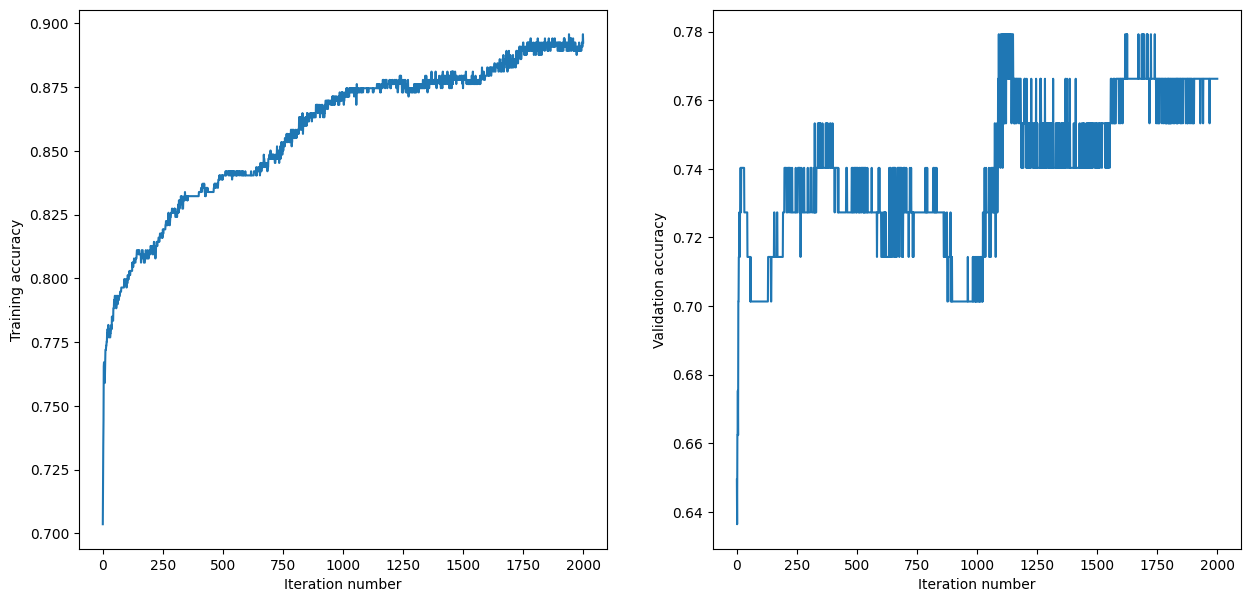

In [13]:
# Original hyperparameters
TwoLayerTraining(32, torch.relu, torch.optim.RMSprop, 1e-3, train_dataloader, val_dataloader, test_dataloader)

Hidden Layer Nodes: 32, Activation: relu, Optimizer: RMSprop, Learning Rate: 0.0001, Dropout: 0
Test Accuracy: 0.7792


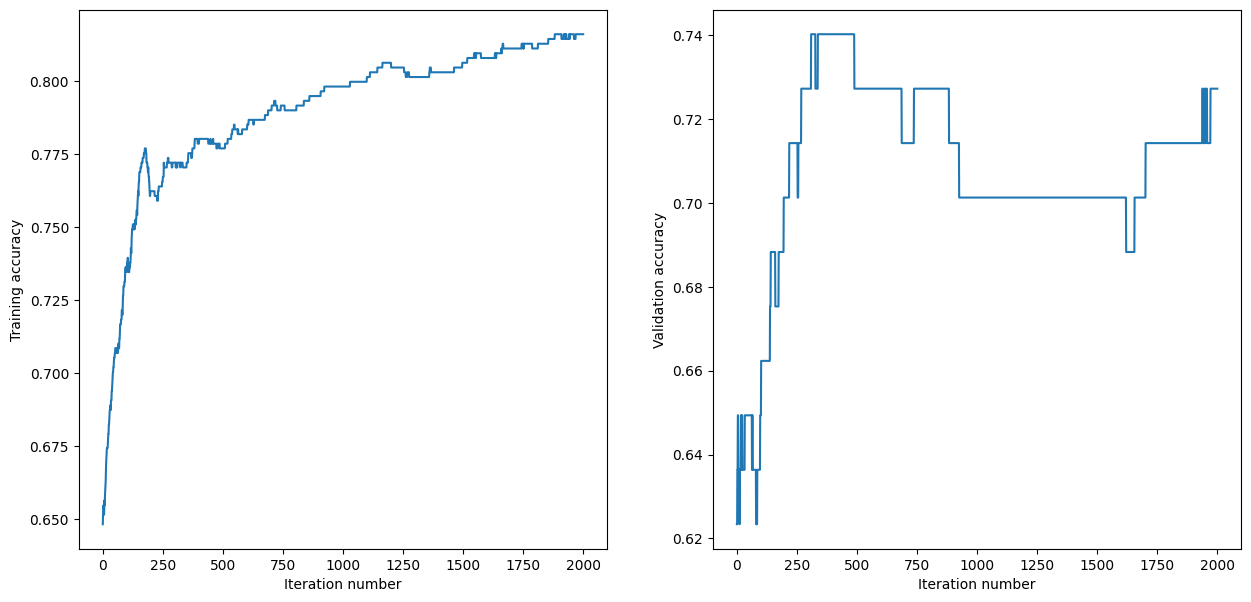

In [20]:
# Reducing learning rate to 1e-4, notice that the curve is much smoother now
TwoLayerTraining(32, torch.relu, torch.optim.RMSprop, 1e-4, train_dataloader, val_dataloader, test_dataloader, dropout=0)

Hidden Layer Nodes: 128, Activation: relu, Optimizer: RMSprop, Learning Rate: 0.0001, Dropout: 0
Test Accuracy: 0.7532


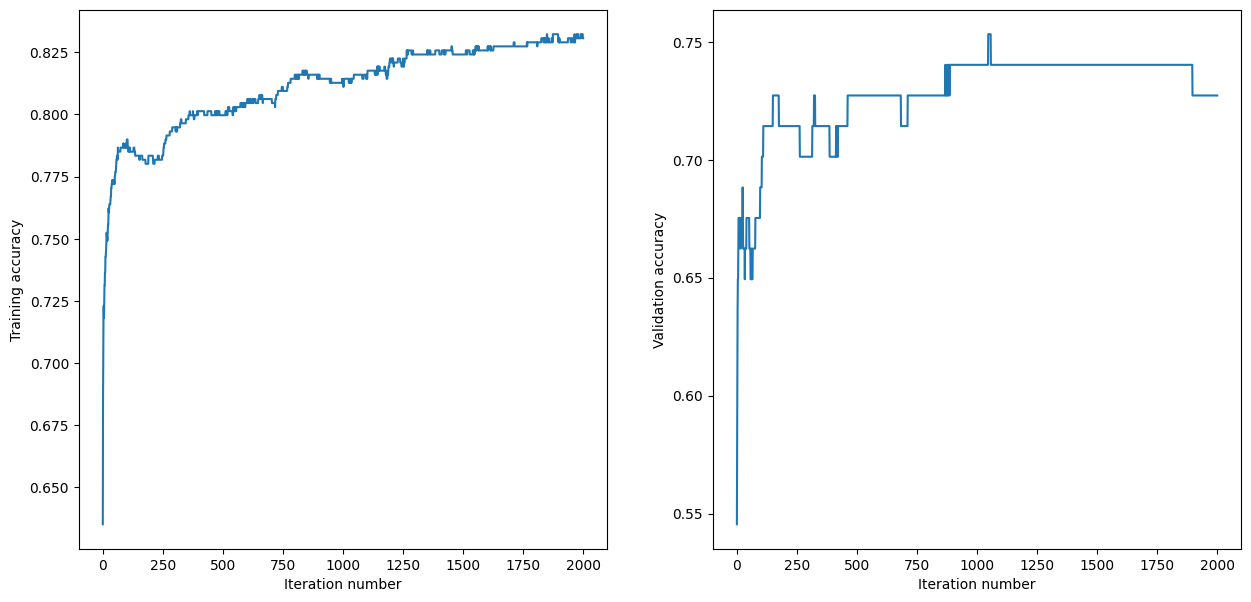

In [46]:
# Reducing learning rate to 1e-4 and trying 128 hidden nodes
TwoLayerTraining(128, torch.relu, torch.optim.RMSprop, 1e-4, train_dataloader, val_dataloader, test_dataloader, dropout=0)

Hidden Layer Nodes: 512, Activation: relu, Optimizer: RMSprop, Learning Rate: 0.0001, Dropout: 0
Test Accuracy: 0.7662


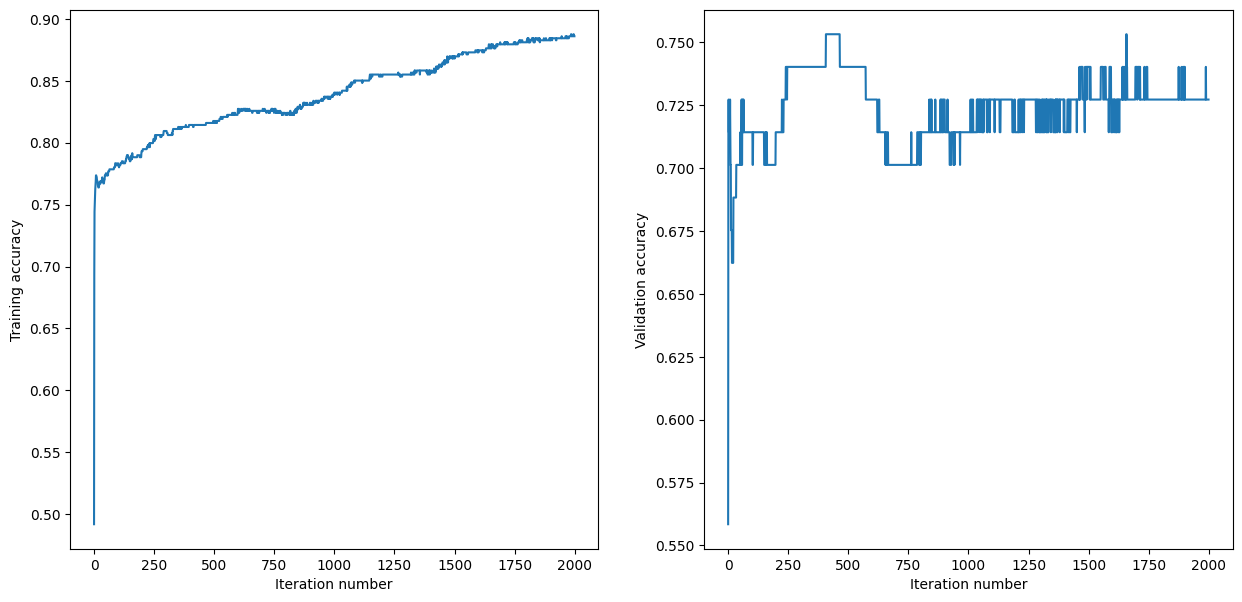

In [47]:
# Reducing learning rate to 1e-4 and trying 512 hidden nodes
TwoLayerTraining(512, torch.relu, torch.optim.RMSprop, 1e-4, train_dataloader, val_dataloader, test_dataloader, dropout=0)

Hidden Layer Nodes: 512, Activation: relu, Optimizer: RMSprop, Learning Rate: 1e-05, Dropout: 0
Test Accuracy: 0.8052


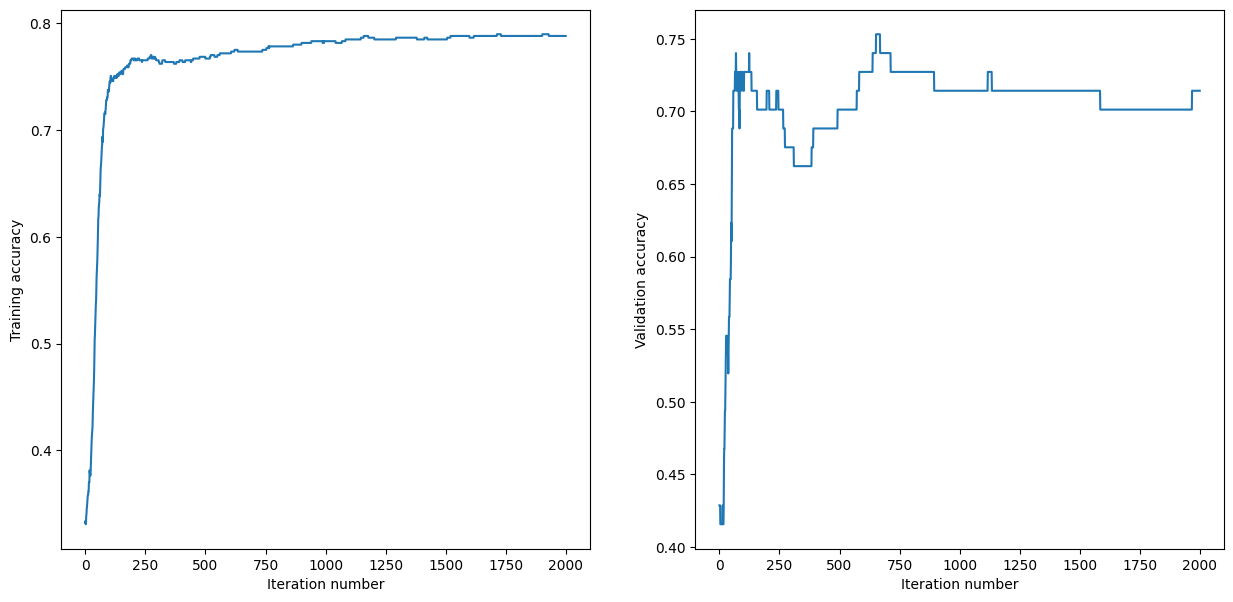

In [48]:
# Trying 512 hidden nodes with learning rate of 1e-5
TwoLayerTraining(512, torch.relu, torch.optim.RMSprop, 1e-5, train_dataloader, val_dataloader, test_dataloader, dropout=0)

Hidden Layer Nodes: 1024, Activation: relu, Optimizer: RMSprop, Learning Rate: 1e-05, Dropout: 0
Test Accuracy: 0.7922


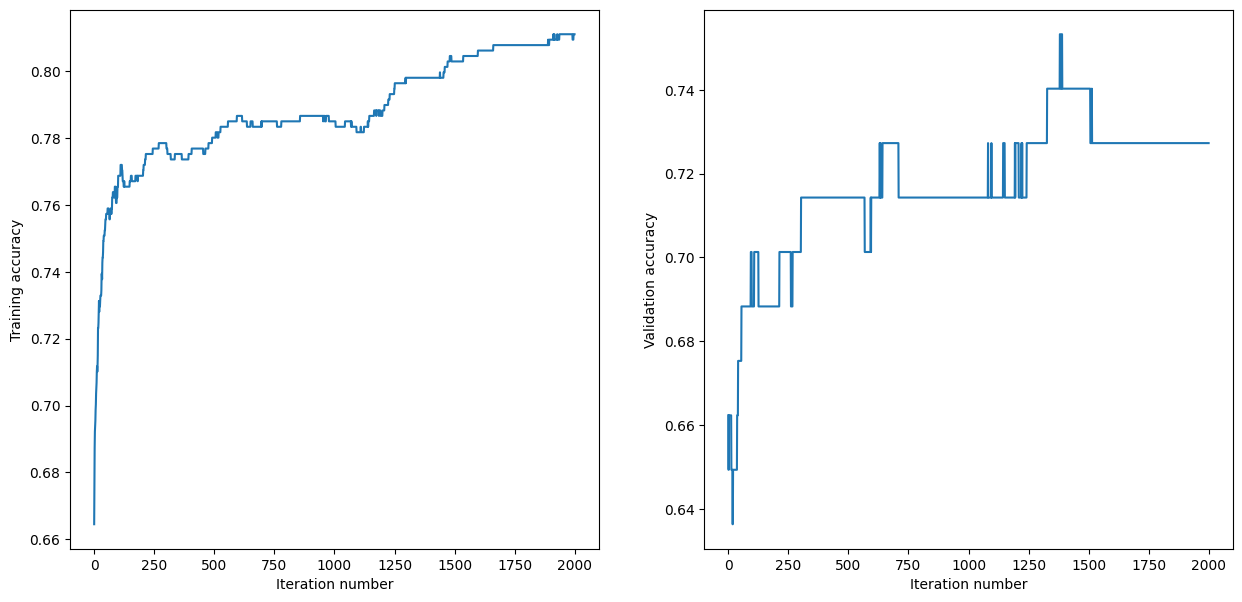

In [49]:
# Trying 1024 hidden nodes with learning rate of 1e-5
TwoLayerTraining(1024, torch.relu, torch.optim.RMSprop, 1e-5, train_dataloader, val_dataloader, test_dataloader, dropout=0)

#### RAdam

Hidden Layer Nodes: 32, Activation: relu, Optimizer: RAdam, Learning Rate: 0.0001, Dropout: 0
Test Accuracy: 0.7662


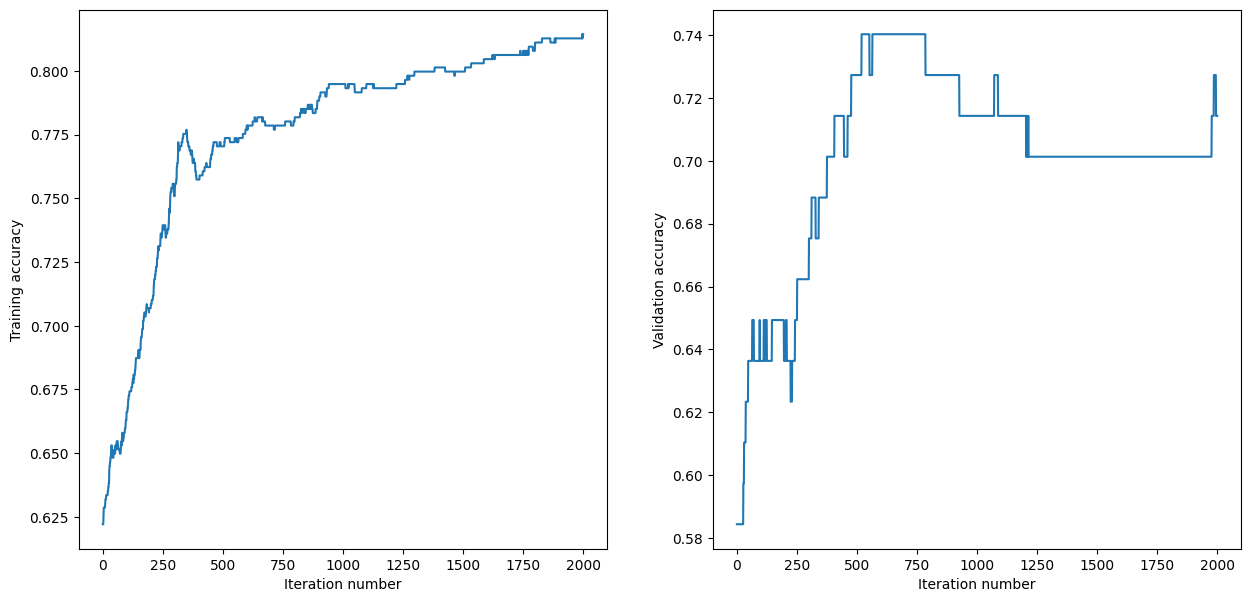

In [30]:
# Reducing learning rate to 1e-4 and testing with RAdam
TwoLayerTraining(32, torch.relu, torch.optim.RAdam, 1e-4, train_dataloader, val_dataloader, test_dataloader, dropout=0)

Hidden Layer Nodes: 128, Activation: relu, Optimizer: RAdam, Learning Rate: 0.0001, Dropout: 0
Test Accuracy: 0.7532


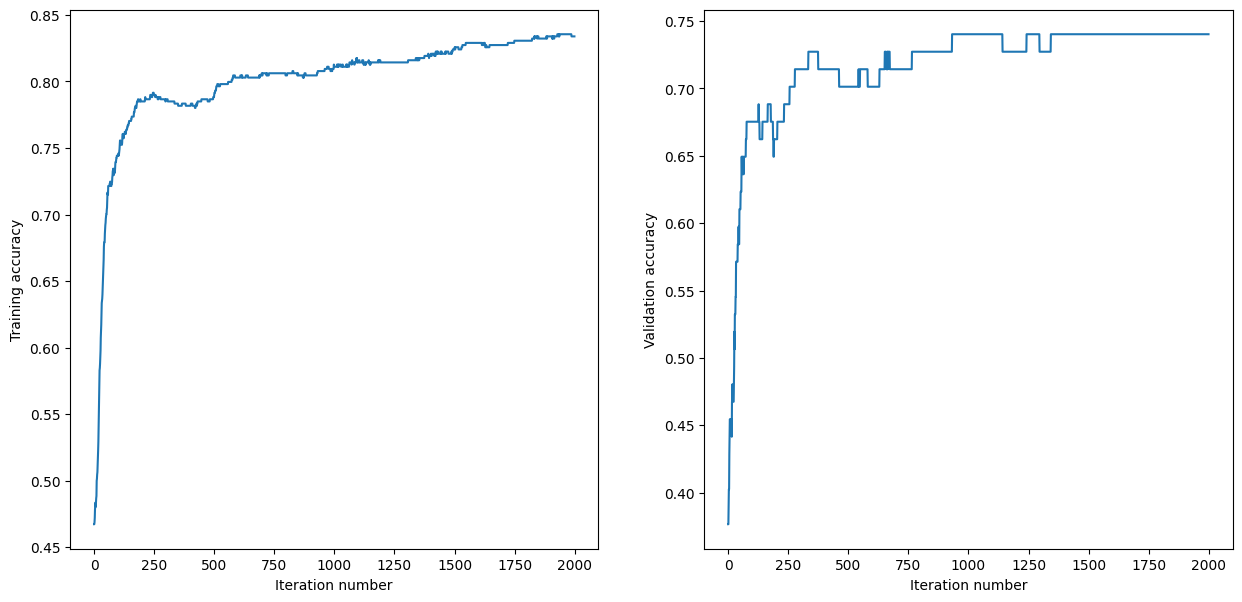

In [25]:
# Reducing learning rate to 1e-4 and testing with RAdam and 128 hidden nodes
TwoLayerTraining(128, torch.relu, torch.optim.RAdam, 1e-4, train_dataloader, val_dataloader, test_dataloader, dropout=0)

Hidden Layer Nodes: 256, Activation: relu, Optimizer: RAdam, Learning Rate: 0.0001, Dropout: 0
Test Accuracy: 0.7532


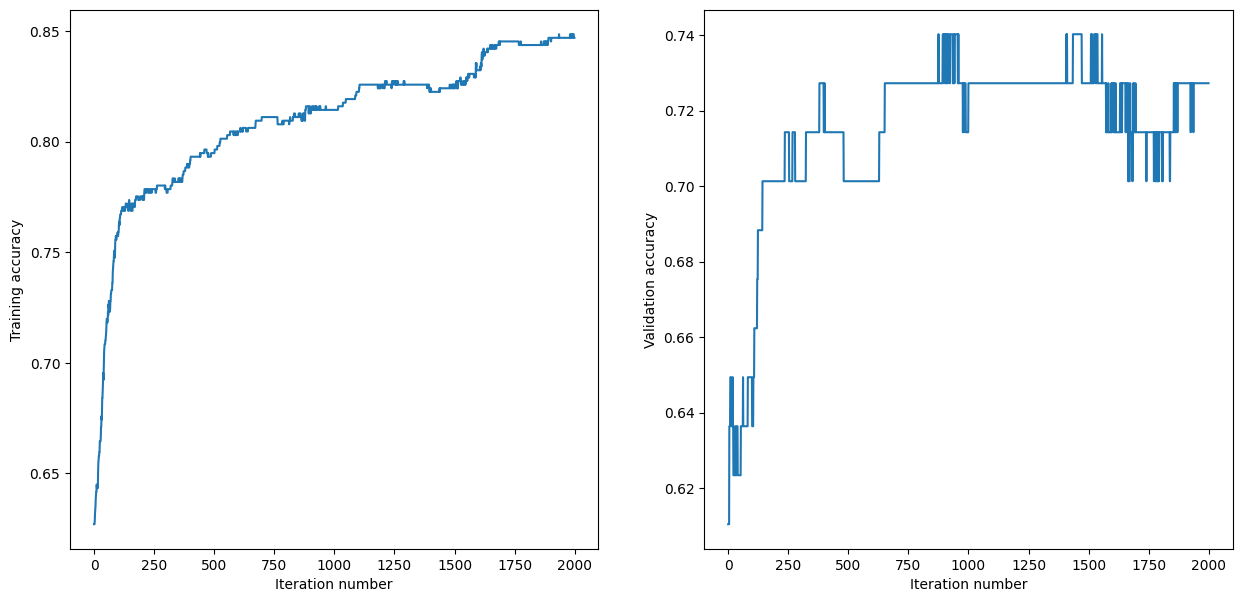

In [31]:
# Reducing learning rate to 1e-4 and testing with RAdam and 256 hidden nodes
TwoLayerTraining(256, torch.relu, torch.optim.RAdam, 1e-4, train_dataloader, val_dataloader, test_dataloader, dropout=0)

Hidden Layer Nodes: 512, Activation: relu, Optimizer: RAdam, Learning Rate: 1e-05, Dropout: 0
Test Accuracy: 0.7922


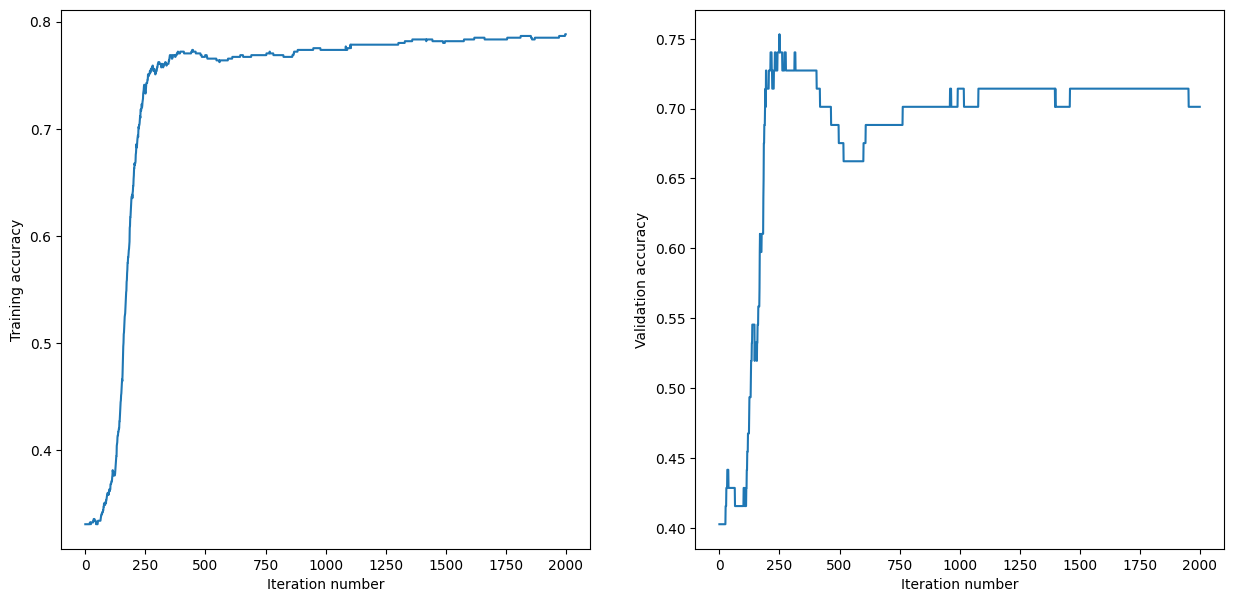

In [50]:
# Reducing learning rate to 1e-5 and testing with RAdam and 512 hidden nodes
TwoLayerTraining(512, torch.relu, torch.optim.RAdam, 1e-5, train_dataloader, val_dataloader, test_dataloader, dropout=0)

Hidden Layer Nodes: 1024, Activation: relu, Optimizer: RAdam, Learning Rate: 1e-05, Dropout: 0
Test Accuracy: 0.7922


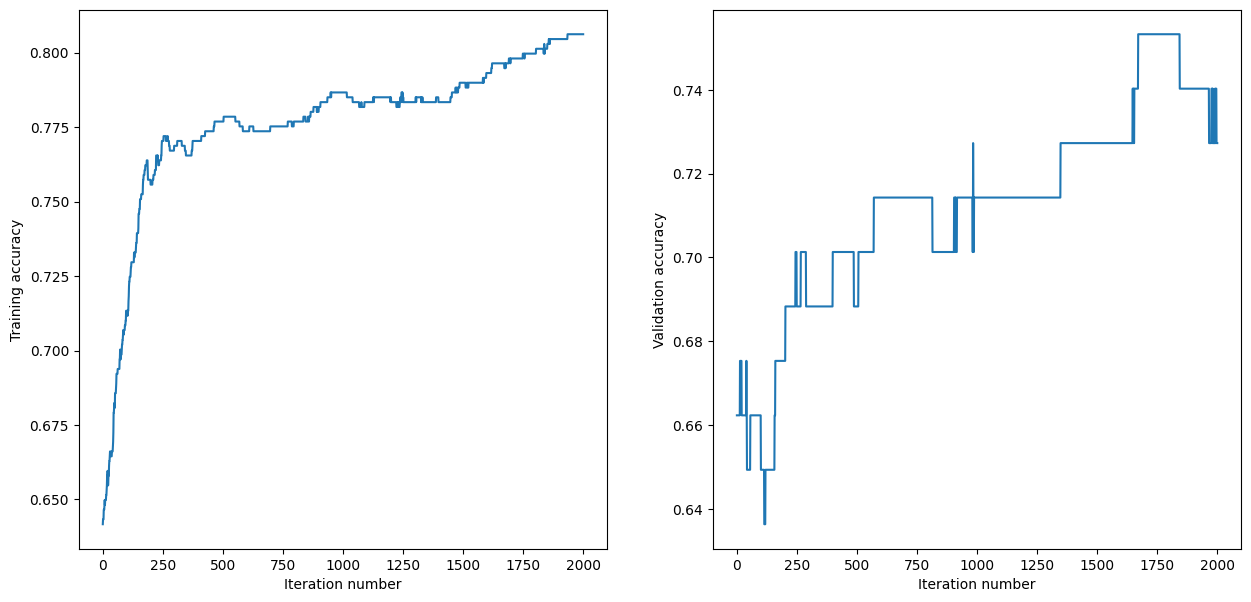

In [51]:
# Reducing learning rate to 1e-5 and testing with RAdam and 1024 hidden nodes
TwoLayerTraining(1024, torch.relu, torch.optim.RAdam, 1e-5, train_dataloader, val_dataloader, test_dataloader, dropout=0)

#### Adam

Hidden Layer Nodes: 32, Activation: relu, Optimizer: Adam, Learning Rate: 0.001, Dropout: 0
Test Accuracy: 0.7792


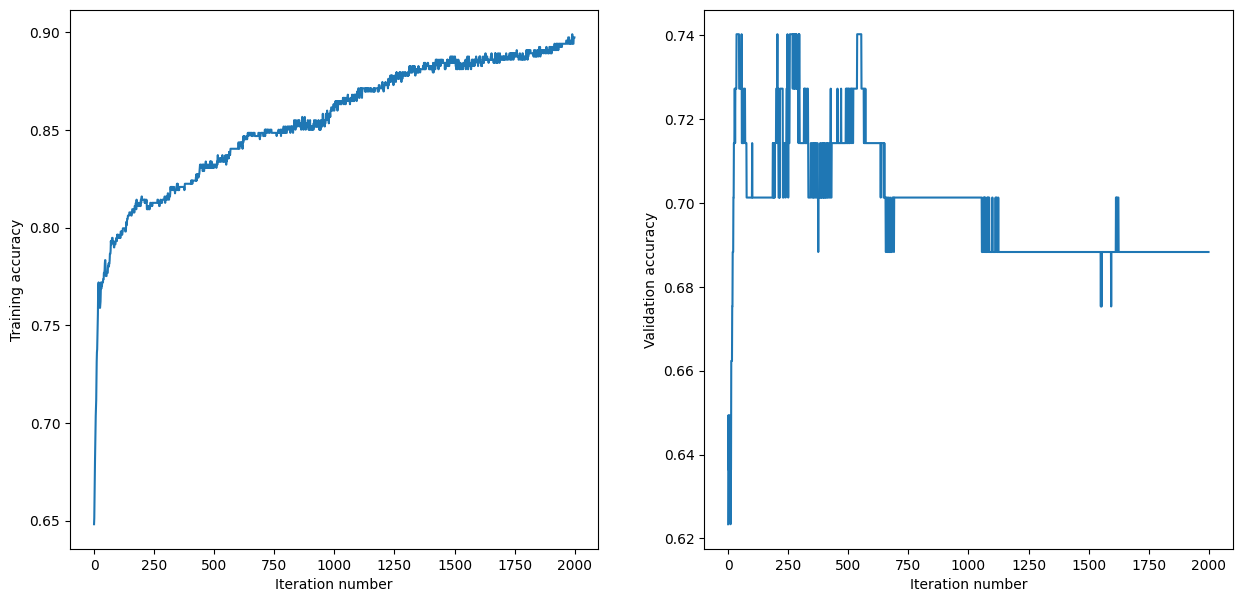

In [16]:
# Reducing learning rate to 1e-3 and testing with Adam
TwoLayerTraining(32, torch.relu, torch.optim.Adam, 1e-3, train_dataloader, val_dataloader, test_dataloader)

Hidden Layer Nodes: 32, Activation: relu, Optimizer: Adam, Learning Rate: 0.0001, Dropout: 0
Test Accuracy: 0.7662


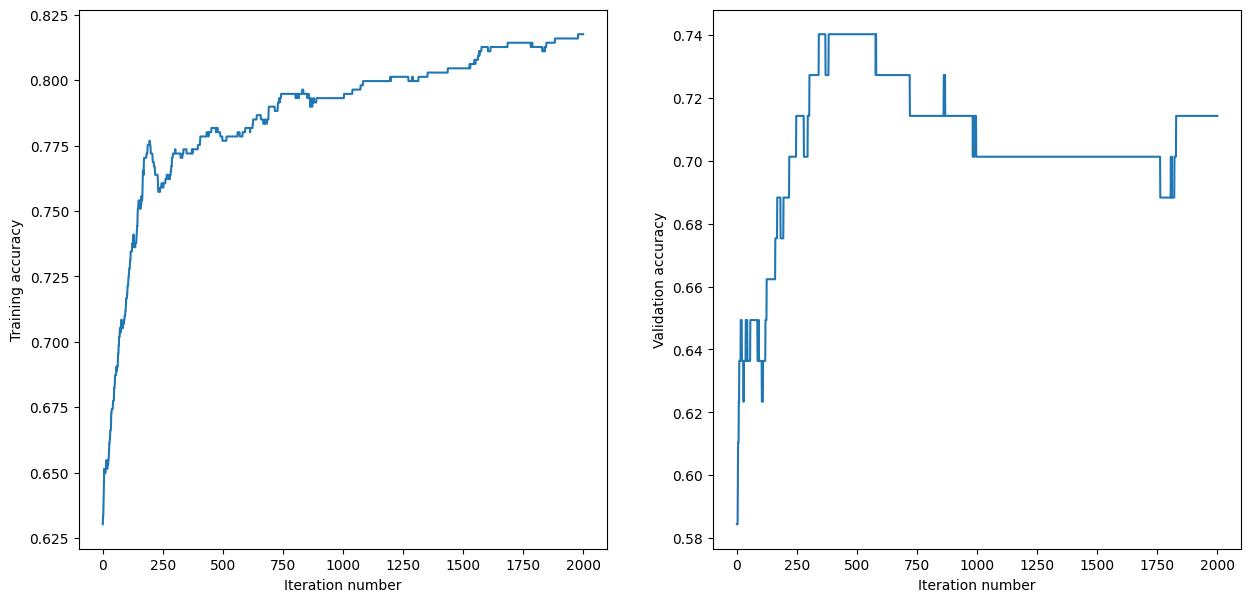

In [37]:
# Reducing learning rate to 1e-4 and testing with Adam
TwoLayerTraining(32, torch.relu, torch.optim.Adam, 1e-4, train_dataloader, val_dataloader, test_dataloader)

Hidden Layer Nodes: 64, Activation: relu, Optimizer: Adam, Learning Rate: 0.0001, Dropout: 0
Test Accuracy: 0.7532


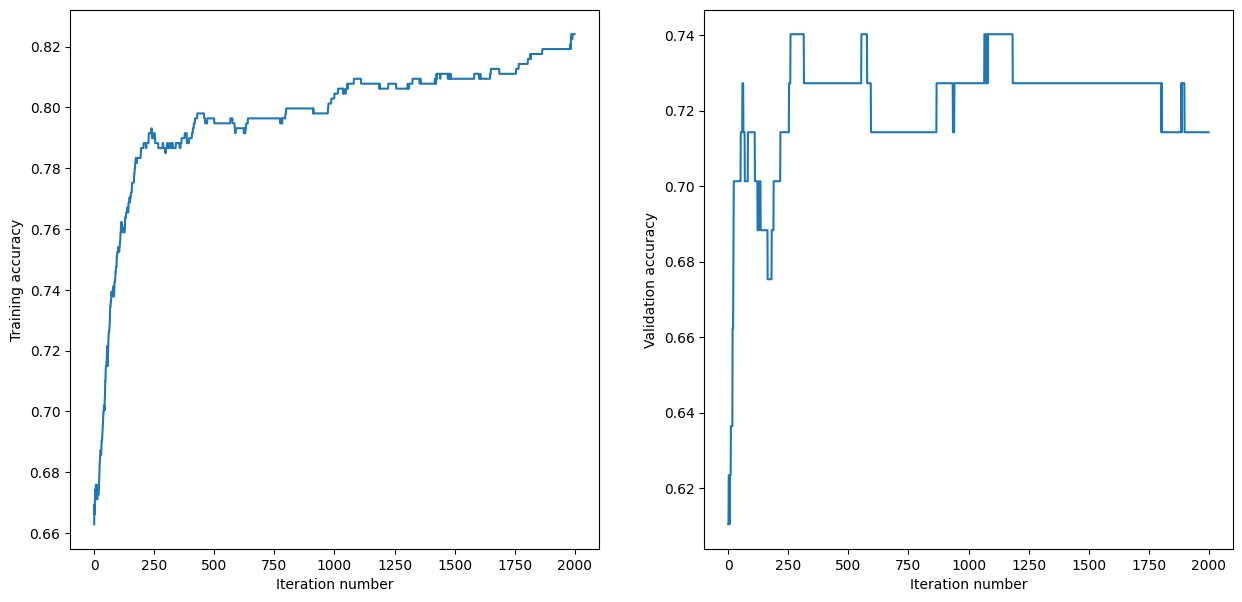

In [38]:
# Reducing learning rate to 1e-4, testing with Adam and 64 hidden nodes
TwoLayerTraining(64, torch.relu, torch.optim.Adam, 1e-4, train_dataloader, val_dataloader, test_dataloader)

Hidden Layer Nodes: 128, Activation: relu, Optimizer: Adam, Learning Rate: 0.0001, Dropout: 0
Test Accuracy: 0.7532


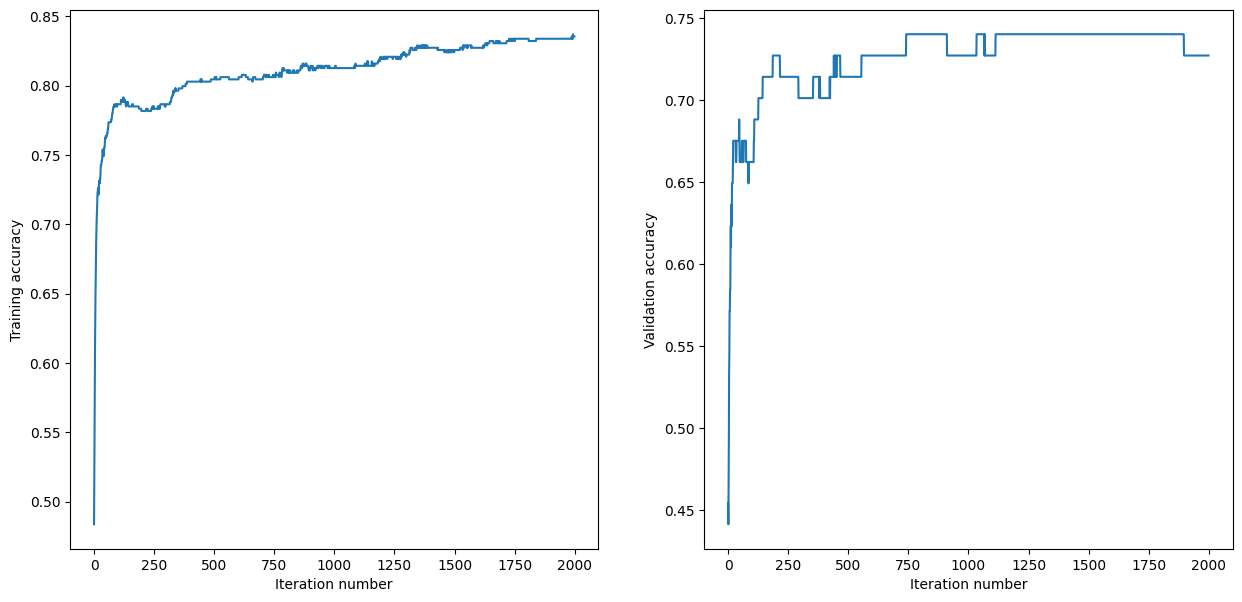

In [32]:
# Reducing learning rate to 1e-4, testing with Adam and 128 hidden nodes
TwoLayerTraining(128, torch.relu, torch.optim.Adam, 1e-4, train_dataloader, val_dataloader, test_dataloader)

Hidden Layer Nodes: 256, Activation: relu, Optimizer: Adam, Learning Rate: 0.0001, Dropout: 0
Test Accuracy: 0.7532


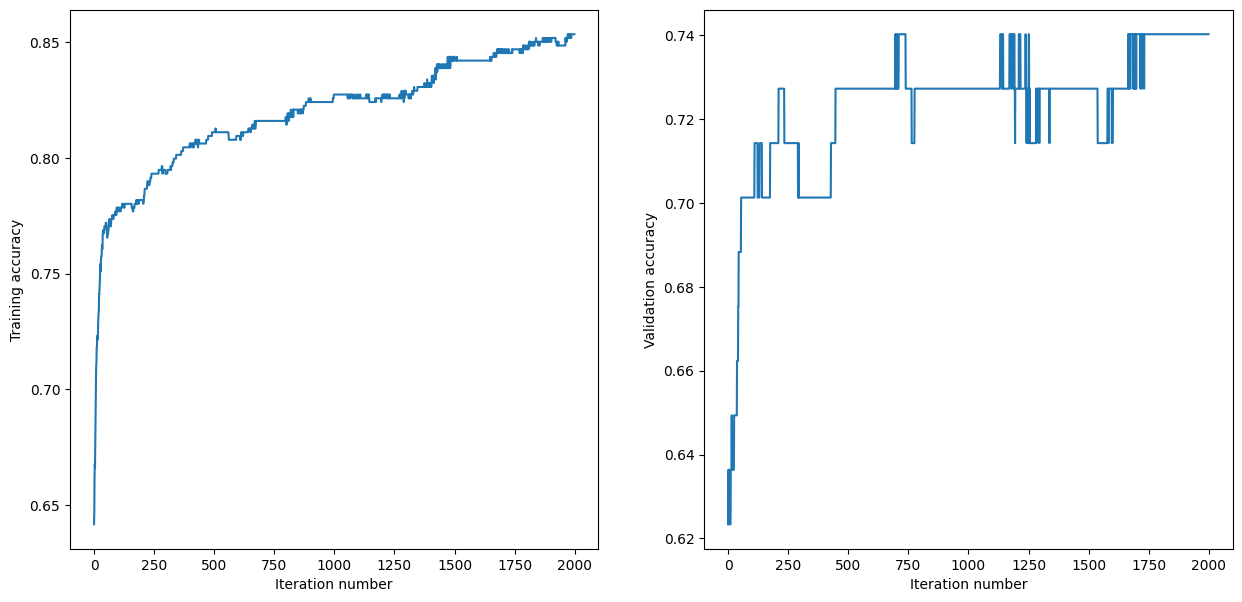

In [29]:
# Reducing learning rate to 1e-4, testing with Adam and 256 hidden nodes
TwoLayerTraining(256, torch.relu, torch.optim.Adam, 1e-4, train_dataloader, val_dataloader, test_dataloader,dropout=0)

Hidden Layer Nodes: 512, Activation: relu, Optimizer: Adam, Learning Rate: 0.0001, Dropout: 0
Test Accuracy: 0.7662


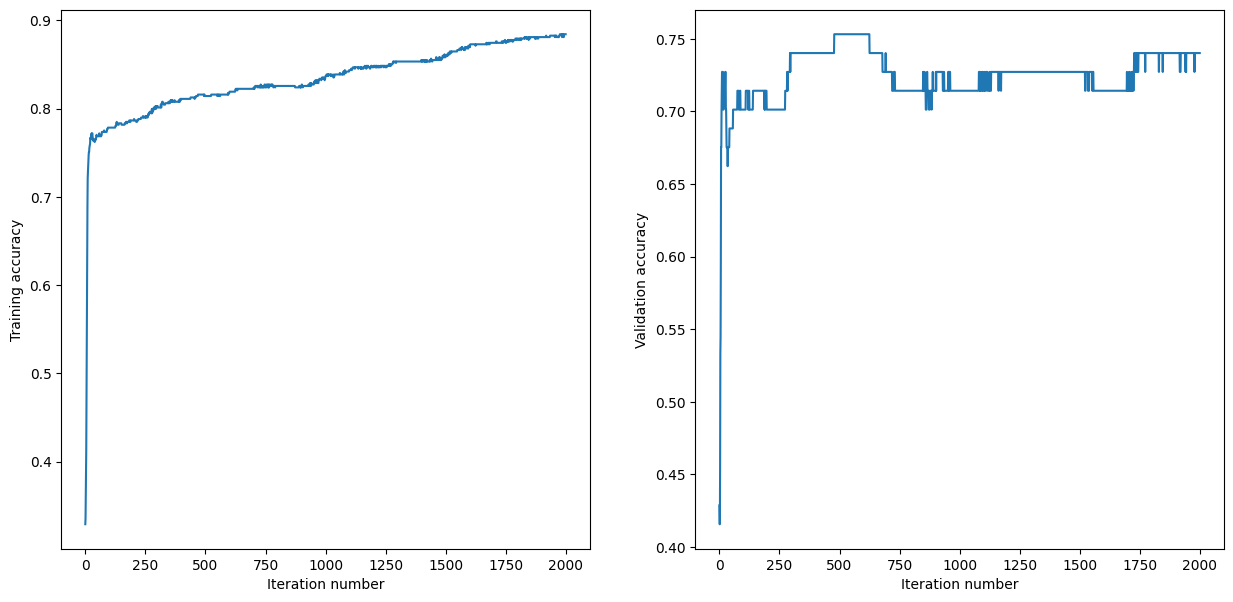

In [33]:
# Reducing learning rate to 1e-4, testing with Adam and 512 hidden nodes
TwoLayerTraining(512, torch.relu, torch.optim.Adam, 1e-4, train_dataloader, val_dataloader, test_dataloader,dropout=0)

Hidden Layer Nodes: 512, Activation: relu, Optimizer: Adam, Learning Rate: 1e-05, Dropout: 0
Test Accuracy: 0.8052


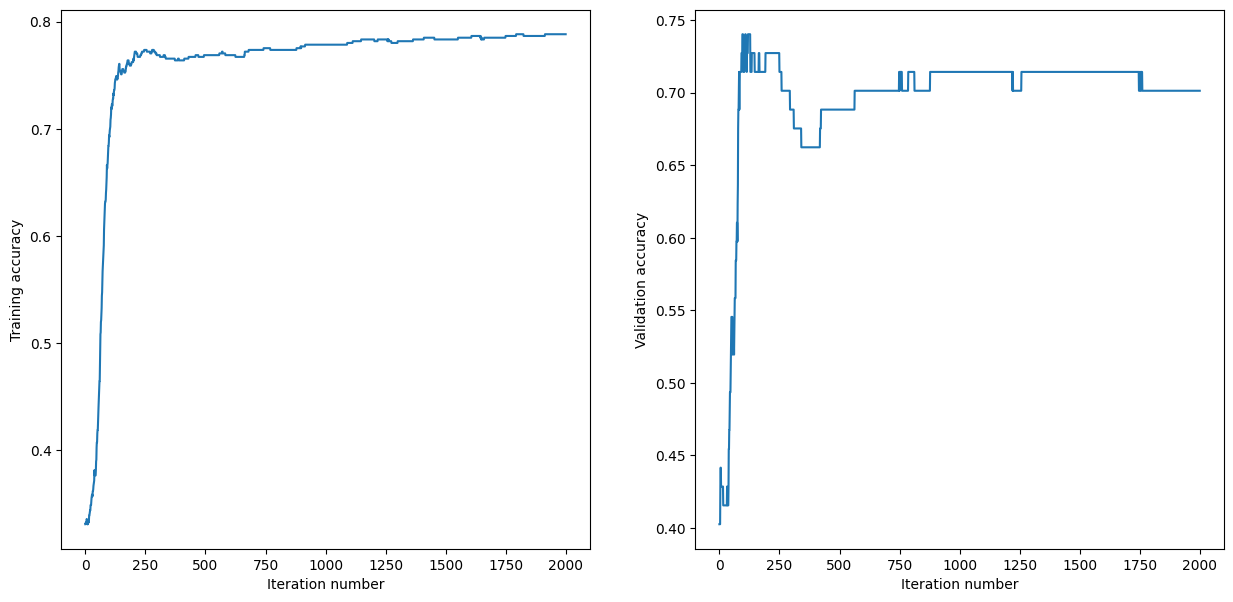

In [39]:
# Reducing learning rate to 1e-5, testing with Adam and 512 hidden nodes
TwoLayerTraining(512, torch.relu, torch.optim.Adam, 1e-5, train_dataloader, val_dataloader, test_dataloader)

Hidden Layer Nodes: 1024, Activation: relu, Optimizer: Adam, Learning Rate: 1e-05, Dropout: 0
Test Accuracy: 0.7922


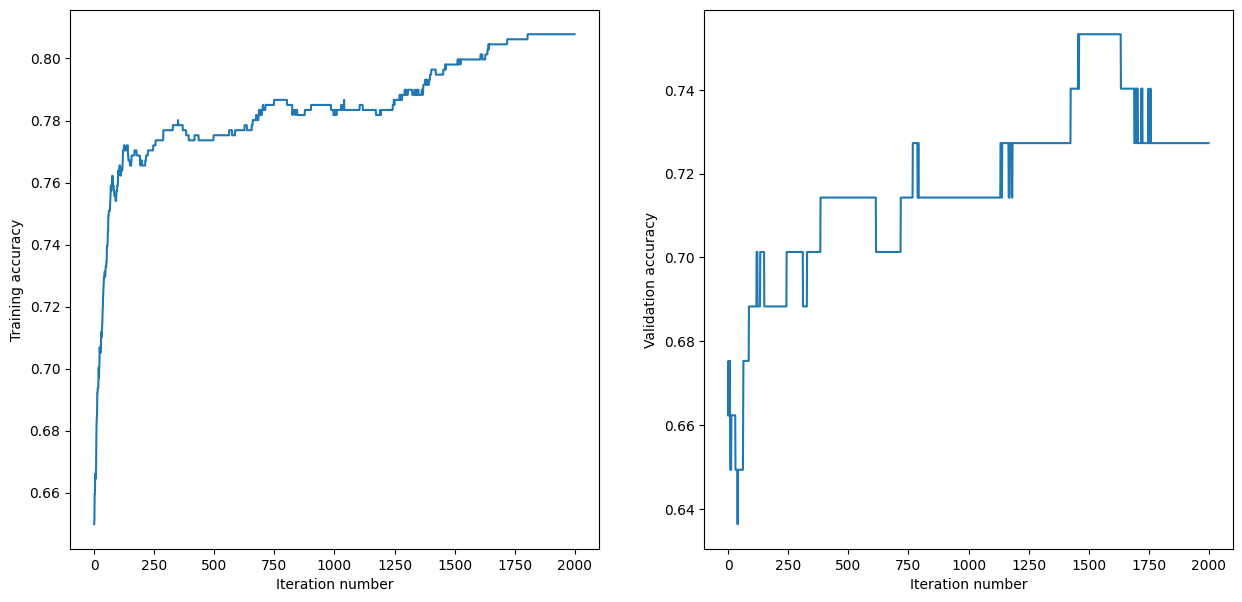

In [40]:
# Reducing learning rate to 1e-5, testing with Adam and 1024 hidden nodes
TwoLayerTraining(1024, torch.relu, torch.optim.Adam, 1e-5, train_dataloader, val_dataloader, test_dataloader)

### Training Final Model

In [52]:
def final_model_training(n_h=512, activation=torch.relu, optim=torch.optim.Adam, lr=1e-5, 
                         train=train_dataloader, val=val_dataloader, test=test_dataloader, dropout=0, epochs=2000):
    torch.manual_seed(42)
    print(f"Hidden Layer Nodes: {n_h}, Activation: {activation.__name__}, Optimizer: {optim.__name__}, Learning Rate: {lr}, Dropout: {dropout}")
    model = TwoLayerNN(n_x = 8, n_h = n_h, n_y = 1, activation = activation, dropout=dropout).to(device)
    train_accs, val_accs = trainer(model, train, val, test, epochs=epochs, optim=optim, lr=lr)
    show_training_curves(train_accs, val_accs)
    return model

Hidden Layer Nodes: 512, Activation: relu, Optimizer: Adam, Learning Rate: 1e-05, Dropout: 0
Test Accuracy: 0.8052


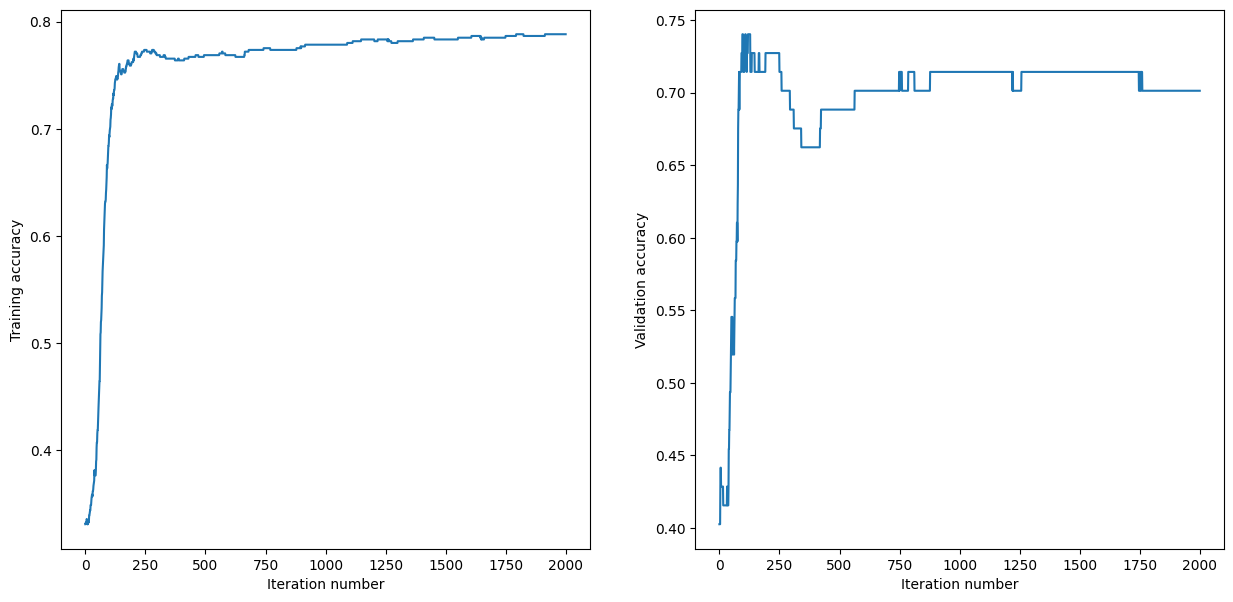

In [53]:
final_model = final_model_training()

### Saving the model

In [55]:
torch.save(final_model.state_dict(), 'final_model.pth')

### Loading the model

In [60]:
test_model = TwoLayerNN(n_x = 8, n_h = 512, n_y = 1, activation = torch.relu)
test_model.load_state_dict(torch.load('final_model.pth'))

<All keys matched successfully>

### Testing the loaded model

In [56]:
def test(model, test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            # Get inputs and labels from test loader
            inputs = inputs.to(device, torch.float32)
            labels = labels.to(device, torch.float32)

            # Forward pass and predict class using max
            outputs = model(inputs)
            outputs = outputs.view(outputs.size(0))

            predicted = torch.round(outputs.data)

            # Check if predicted class matches label and count numbler of correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    # Compute final accuracy and display
    test_accuracy = correct/total
    print(f'Test Accuracy: {test_accuracy:.4f}')
    return

In [61]:
test(test_model, test_dataloader)

Test Accuracy: 0.8052
